# Citrus Green

The notebook tries to use the model trained on casssava trained dataset and retrain its head on the small citrus-green dataset.

The attempt was though of because some of the symptoms of the diseases in cassava plant and citrus plants are the same.


## Importing libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import os
import cv2
import sys
from pylab import rcParams
from PIL import Image
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Input, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import InceptionV3, Xception
from tensorflow.keras.mixed_precision import experimental as mixed_precision
from sklearn.model_selection import StratifiedShuffleSplit

## Looking at the datset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Unzipping the data
!unzip -uq "/content/drive/My Drive/citrus_green/archive.zip" -d "/content/drive/My Drive/citrus_green/"

In [ ]:
classes = os.listdir('/content/drive/My Drive/citrus_green/citrus_leaves_prepared/train/')
print(f'Classes present in the dataset : {classes}')

Classes present in the dataset : ['blackspot', 'canker', 'greening', 'healthy']


In [ ]:
train_count = []
val_count = []
for d_class in classes:
  train_count.append(len(os.listdir(f'/content/drive/My Drive/citrus_green/citrus_leaves_prepared/train/{d_class}')))
  val_count.append(len(os.listdir(f'/content/drive/My Drive/citrus_green/citrus_leaves_prepared/validation/{d_class}')))

Text(0.5, 1.0, 'Data Spread among different classes')

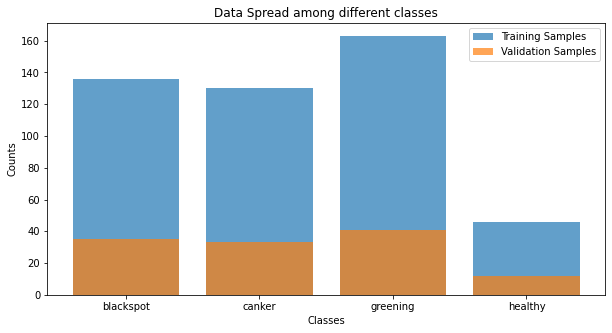

In [ ]:
plt.figure(figsize=(10,5))
plt.bar(classes, train_count, alpha=0.7,label='Training Samples')
plt.bar(classes, val_count, alpha=0.7,label='Validation Samples')
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.legend()
plt.title('Data Spread among different classes')

## Preprocessing and loading generators

In [ ]:
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor
!pip install albumentations==0.5.2

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-w2p6dhf4
  Running command git clone -q https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-w2p6dhf4
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-cp36-none-any.whl size=29531 sha256=451ffbd992d869abbf4e2507b754dffc15c74e953b37bed79d3cdbd6c13c69cb
  Stored in directory: /tmp/pip-ephem-wheel-cache-h50gaw79/wheels/d9/10/55/6fca35a4072f87d694876d56ece64db3846cf45e1da1c381fe
Successfully built ImageDataAugmentor


In [ ]:
batch_size=16
image_size=300

input_shape = (image_size, image_size, 3)
target_size = (image_size, image_size)

In [ ]:
img_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomCrop(image_size, image_size),
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.25),
        tf.keras.layers.experimental.preprocessing.RandomZoom((-0.25, 0.25), (-0.25, 0.25)),
    ])

In [ ]:
from ImageDataAugmentor.image_data_augmentor import *
import albumentations as A

train_augmentations = A.Compose([
            A.RandomCrop(image_size, image_size, p=1),
            A.Cutout(p=0.5),
            A.Flip(p=0.5),
            A.ShiftScaleRotate(p=0.5),
            A.HueSaturationValue(p=0.5, hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2),
            A.RandomBrightnessContrast(p=0.5, brightness_limit=(-0.2,0.2), contrast_limit=(-0.2, 0.2)),
            A.ToFloat()
            ], p=1)

val_augmentations = A.Compose([
                A.CenterCrop(image_size, image_size, p=1),
                A.ToFloat()
                ], p=1)

In [ ]:
train_generator = ImageDataAugmentor(augment=train_augmentations)
val_generator = ImageDataAugmentor(augment=val_augmentations)

train_datagen = train_generator.flow_from_directory(
    directory='/content/drive/My Drive/citrus_green/citrus_leaves_prepared/train',
    target_size=target_size,
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical',
    seed=2021)

val_datagen = val_generator.flow_from_directory(
    directory='/content/drive/My Drive/citrus_green/citrus_leaves_prepared/validation',
    target_size=target_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical',
    seed=2021)


Found 475 images belonging to 4 classes.
Found 121 images belonging to 4 classes.


# Create models

In [ ]:
def repurpose_cassava_Inception(wts):
    base_model = InceptionV3(include_top=False, weights=None, input_shape=input_shape)
    # Rebuild top
    inputs = Input(shape=input_shape)

    model = base_model(inputs)
    pooling = GlobalAveragePooling2D()(model)
    dropout = Dropout(0.2)(pooling)

    outputs_cassava = Dense(5, activation="softmax", name="dense", dtype='float32')(dropout)

    # Compile
    inception = Model(inputs=inputs, outputs=outputs_cassava)
    inception.load_weights(wts)
    # pop the dense layer
    inception._layers.pop()

    outputs_citrus = Dense(len(classes), activation="softmax", name="dense", dtype='float32')(dropout)
    inception_citrus = Model(inputs=inputs, outputs=outputs_citrus)

    optimizer = tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2, from_logits=True)

    inception_citrus.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    for layer in inception_citrus.layers[:-1]:
      layer.trainable = False

    return inception_citrus

In [ ]:
def repurpose_cassava_Xception(wts):
    base_model = Xception(include_top=False, weights=None, input_shape=input_shape)
    # Rebuild top
    inputs = Input(shape=input_shape)

    model = base_model(inputs)
    pooling = GlobalAveragePooling2D()(model)
    dropout = Dropout(0.2, name="above_dense")(pooling)

    outputs_cassava = Dense(5, activation="softmax", name="dense", dtype='float32')(dropout)

    # Load Cassava weights
    xception = Model(inputs=inputs, outputs=outputs_cassava)
    xception.load_weights(wts)
    # pop the dense layer
    xception._layers.pop()

    outputs_citrus = Dense(len(classes), activation="softmax", name="dense", dtype='float32')(dropout)
    xception_citrus = Model(inputs=inputs, outputs=outputs_citrus)

    optimizer = tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2, from_logits=True)

    xception_citrus.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    for layer in xception_citrus.layers[:-1]:
      layer.trainable = False
    return xception_citrus

# Training the head

In [ ]:
epochs=20

model = repurpose_cassava_Inception("/content/drive/My Drive/citrus_green/models/inception 3fold.h5")
model.summary()
model_name = "inception_citrus.h5"
filepath = f"/content/drive/My Drive/citrus_green/models/{model_name}"
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.2,
                               mode='auto', min_delta=0.0001, cooldown=0, min_lr=0),
             EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath=filepath, monitor='val_loss', save_best_only=True, mode='min')]

history = model.fit_generator(generator = train_datagen, epochs=epochs, steps_per_epoch= len(train_datagen),
                              validation_data=val_datagen, validation_steps=len(val_datagen), 
                              callbacks=callbacks)
print("Training finished!")

Model: "model_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_70 (InputLayer)        [(None, 300, 300, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_29  (None, 2048)              0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 8196      
Total params: 21,810,980
Trainable params: 8,196
Non-trainable params: 21,802,784
_________________________________________________________________
Epoch 1/20
30/30 [==============================] - 15s 329ms/step - loss: 1.2519 - accuracy: 0.4655 - val_l

Class labels
{'blackspot': 0, 'canker': 1, 'greening': 2, 'healthy': 3}


Validation Accuracy of the model is 87.60%


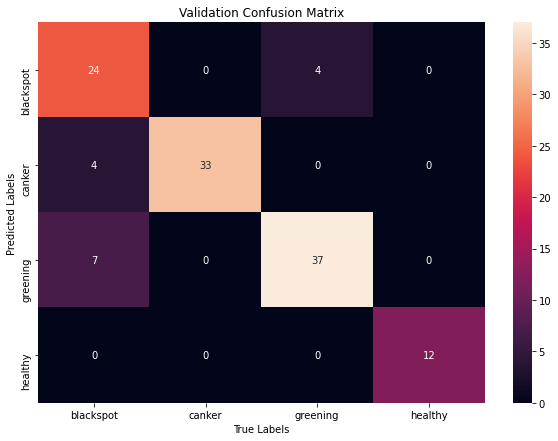

In [ ]:
probabilities = model.predict_generator(val_datagen, len(val_datagen))
prediction_label = np.argmax(probabilities, axis = 1)
val_labels = val_datagen.classes

print('Class labels')
print(val_datagen.class_indices)

classes = val_datagen.class_indices.keys()
print('\n')
#Plotting confusion matrix
cm = confusion_matrix(prediction_label, val_labels)
df_cm = pd.DataFrame(cm, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (10,7))
plt.title('Validation Confusion Matrix')


sns.heatmap(df_cm, annot=True)
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')

acc = ((prediction_label == val_labels).sum())/len(val_labels) * 100

print('Validation Accuracy of the model is %.2f%%' % (acc))

In [ ]:
model.summary()

Model: "model_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_70 (InputLayer)        [(None, 300, 300, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_29  (None, 2048)              0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 8196      
Total params: 21,810,980
Trainable params: 8,196
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
epochs=20

model = repurpose_cassava_Xception("/content/drive/My Drive/citrus_green/models/xception 2fold.h5")
model.summary()
model_name = "xception_citrus.h5"
filepath = f"/content/drive/My Drive/citrus_green/models/{model_name}"
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.2),
             EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath=filepath, monitor='val_accuracy', save_best_only=True, mode='max')]

history = model.fit_generator(generator = train_datagen, epochs=epochs, steps_per_epoch= len(train_datagen),
                              validation_data=val_datagen, validation_steps=len(val_datagen),
                              callbacks=callbacks)
print("Training finished!")

Model: "model_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_68 (InputLayer)        [(None, 300, 300, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_28  (None, 2048)              0         
_________________________________________________________________
above_dense (Dropout)        (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 8196      
Total params: 20,869,676
Trainable params: 8,196
Non-trainable params: 20,861,480
_________________________________________________________________
Epoch 1/20
30/30 [==============================] - 23s 642ms/step - loss: 1.3260 - accuracy: 0.3644 - val_l

Class labels
{'blackspot': 0, 'canker': 1, 'greening': 2, 'healthy': 3}


Validation Accuracy of the model is 89.26%


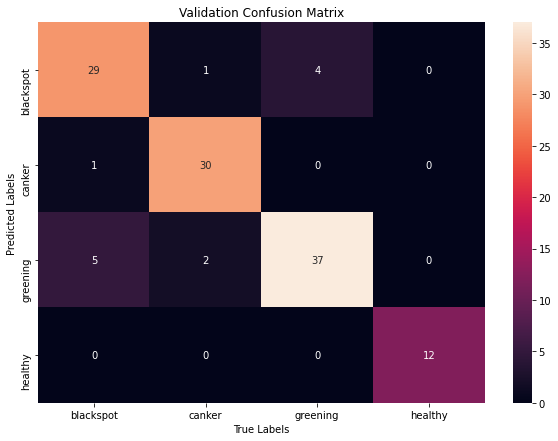

In [ ]:
probabilities = model.predict_generator(val_datagen, len(val_datagen))
prediction_label = np.argmax(probabilities, axis = 1)
val_labels = val_datagen.classes

print('Class labels')
print(val_datagen.class_indices)

classes = val_datagen.class_indices.keys()
print('\n')
#Plotting confusion matrix
cm = confusion_matrix(prediction_label, val_labels)
df_cm = pd.DataFrame(cm, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (10,7))
plt.title('Validation Confusion Matrix')


sns.heatmap(df_cm, annot=True)
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')

acc = ((prediction_label == val_labels).sum())/len(val_labels) * 100

print('Validation Accuracy of the model is %.2f%%' % (acc))

In [ ]:
#END 